In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_thinned_4um_back_10M_300keV.txt"

In [ ]:
def read_electron_data(fname, nevts=1000):
    
    evt = -1
    xinc = 0.0
    yinc = 0.0
    front = True
    energy = 0.0
    
    # Open the file and read the specified number of events.
    l_evt, l_xinc, l_yinc, l_front, l_energy, l_row, l_col, l_counts = [], [], [], [], [], [], [], []
    evts_read = 0
    with open(fname) as f:
        
        # Iterate through all lines.
        for line in f:
            
            # Stop reading if we've read the specified number of events.
            if(evts_read > nevts):
                break
            
            # Get each number in the line, separated by spaces.
            vals = line.rstrip().split(" ")
            
            # Start a new event.
            if(vals[0] == "EV"):
                evt    = vals[1]
                xinc   = vals[2]
                yinc   = vals[3]
                front  = (vals[4] == 1)
                energy = vals[5]
                evts_read += 1
                
            # Add a row for the current event.
            else:
                l_evt.append(int(evt))
                l_xinc.append(float(xinc))
                l_yinc.append(float(yinc))
                l_front.append(front)
                l_energy.append(float(energy))
                l_row.append(int(vals[0]))
                l_col.append(int(vals[1]))
                l_counts.append(int(vals[2]))
    
    # Construct the DataFrame.
    evt_dict = {'event': l_evt, 'xinc': l_xinc, 'yinc': l_yinc, 'front': l_front, 
                'energy': l_energy, 'row': l_row, 'col': l_col, 'counts': l_counts}
    df = pd.DataFrame.from_dict(evt_dict)
    
    return df

In [ ]:
df = read_electron_data(datfile,nevts=100005)

In [ ]:
len(df.event.unique())

In [ ]:
df.to_pickle("EM_4um_back_10M_300keV.pkl")

### Examine individual events

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))

In [ ]:
max(df.xinc.values)

## Evaluate a dataset

In [ ]:
Nevts = 1000

In [ ]:
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

## Train a network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [5]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-5   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 203      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_80cells_noise_100k_202.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
dataset_train = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=10)
dataset_val   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=10)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 100000
Created dataset for events from 0 to -20000
Created dataset for events from -20000 to 20000


In [6]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        tr.val(model, epoch, val_loader)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

Epoch:  203
Train Epoch: 203 [0/80000 (0%)]	Loss: 6.078534	 score_max: 10.880628	 score_min: -2.233463; Accuracy 0.040
Train Epoch: 203 [1000/80000 (1%)]	Loss: 6.140558	 score_max: 16.196941	 score_min: -3.141732; Accuracy 0.034
Train Epoch: 203 [2000/80000 (2%)]	Loss: 6.121253	 score_max: 12.170262	 score_min: -2.817523; Accuracy 0.045
Train Epoch: 203 [3000/80000 (4%)]	Loss: 6.135624	 score_max: 11.543123	 score_min: -2.124538; Accuracy 0.023
Train Epoch: 203 [4000/80000 (5%)]	Loss: 6.058285	 score_max: 10.948215	 score_min: -2.151724; Accuracy 0.045
Train Epoch: 203 [5000/80000 (6%)]	Loss: 6.090260	 score_max: 11.069684	 score_min: -2.154619; Accuracy 0.054
Train Epoch: 203 [6000/80000 (8%)]	Loss: 6.151054	 score_max: 11.453644	 score_min: -2.132093; Accuracy 0.033
Train Epoch: 203 [7000/80000 (9%)]	Loss: 6.184347	 score_max: 13.214658	 score_min: -3.061974; Accuracy 0.036
Train Epoch: 203 [8000/80000 (10%)]	Loss: 6.191022	 score_max: 12.454246	 score_min: -2.130233; Accuracy 0.043


--Val Epoch: 203 [0/20000 (0%)]	Loss: 5.969028	 score_max: 6.282363	 score_min: -1.188003; Accuracy 0.101
--Val Epoch: 203 [1000/20000 (5%)]	Loss: 6.017280	 score_max: 7.271797	 score_min: -1.425732; Accuracy 0.104
--Val Epoch: 203 [2000/20000 (10%)]	Loss: 5.923928	 score_max: 6.097560	 score_min: -1.312694; Accuracy 0.109
--Val Epoch: 203 [3000/20000 (15%)]	Loss: 5.953456	 score_max: 8.676144	 score_min: -1.510380; Accuracy 0.094
--Val Epoch: 203 [4000/20000 (20%)]	Loss: 5.922404	 score_max: 6.417382	 score_min: -1.240763; Accuracy 0.098
--Val Epoch: 203 [5000/20000 (25%)]	Loss: 5.975354	 score_max: 6.525107	 score_min: -1.258587; Accuracy 0.101
--Val Epoch: 203 [6000/20000 (30%)]	Loss: 5.897192	 score_max: 6.302308	 score_min: -1.221896; Accuracy 0.113
--Val Epoch: 203 [7000/20000 (35%)]	Loss: 5.999245	 score_max: 6.310661	 score_min: -1.252879; Accuracy 0.096
--Val Epoch: 203 [8000/20000 (40%)]	Loss: 6.017125	 score_max: 7.523828	 score_min: -1.409603; Accuracy 0.102
--Val Epoch: 20

Train Epoch: 204 [54000/80000 (68%)]	Loss: 6.128606	 score_max: 11.027635	 score_min: -2.179147; Accuracy 0.032
Train Epoch: 204 [55000/80000 (69%)]	Loss: 6.069726	 score_max: 10.432649	 score_min: -2.211958; Accuracy 0.041
Train Epoch: 204 [56000/80000 (70%)]	Loss: 6.230190	 score_max: 12.488357	 score_min: -2.217355; Accuracy 0.032
Train Epoch: 204 [57000/80000 (71%)]	Loss: 6.129965	 score_max: 11.522884	 score_min: -1.967997; Accuracy 0.039
Train Epoch: 204 [58000/80000 (72%)]	Loss: 6.206769	 score_max: 12.243993	 score_min: -2.361238; Accuracy 0.041
Train Epoch: 204 [59000/80000 (74%)]	Loss: 6.135161	 score_max: 11.696203	 score_min: -2.117202; Accuracy 0.033
Train Epoch: 204 [60000/80000 (75%)]	Loss: 6.079113	 score_max: 11.124859	 score_min: -1.964215; Accuracy 0.036
Train Epoch: 204 [61000/80000 (76%)]	Loss: 6.223713	 score_max: 11.476685	 score_min: -2.400132; Accuracy 0.035
Train Epoch: 204 [62000/80000 (78%)]	Loss: 6.210761	 score_max: 12.651951	 score_min: -2.166513; Accurac

Train Epoch: 205 [31000/80000 (39%)]	Loss: 6.139960	 score_max: 10.838536	 score_min: -2.346669; Accuracy 0.026
Train Epoch: 205 [32000/80000 (40%)]	Loss: 6.122826	 score_max: 10.312763	 score_min: -2.144645; Accuracy 0.027
Train Epoch: 205 [33000/80000 (41%)]	Loss: 6.080837	 score_max: 11.329291	 score_min: -2.209992; Accuracy 0.029
Train Epoch: 205 [34000/80000 (42%)]	Loss: 6.200155	 score_max: 12.626998	 score_min: -2.313882; Accuracy 0.028
Train Epoch: 205 [35000/80000 (44%)]	Loss: 6.151024	 score_max: 10.907179	 score_min: -2.075783; Accuracy 0.039
Train Epoch: 205 [36000/80000 (45%)]	Loss: 6.138854	 score_max: 10.902103	 score_min: -2.059907; Accuracy 0.033
Train Epoch: 205 [37000/80000 (46%)]	Loss: 6.147877	 score_max: 10.986190	 score_min: -2.104090; Accuracy 0.025
Train Epoch: 205 [38000/80000 (48%)]	Loss: 6.167878	 score_max: 11.305311	 score_min: -2.036179; Accuracy 0.026
Train Epoch: 205 [39000/80000 (49%)]	Loss: 6.208867	 score_max: 11.765294	 score_min: -2.327980; Accurac

Train Epoch: 206 [7000/80000 (9%)]	Loss: 6.123899	 score_max: 10.780577	 score_min: -2.012161; Accuracy 0.026
Train Epoch: 206 [8000/80000 (10%)]	Loss: 6.235456	 score_max: 12.623363	 score_min: -2.336477; Accuracy 0.038
Train Epoch: 206 [9000/80000 (11%)]	Loss: 6.177792	 score_max: 11.561886	 score_min: -2.310153; Accuracy 0.036
Train Epoch: 206 [10000/80000 (12%)]	Loss: 6.229512	 score_max: 11.862229	 score_min: -2.404844; Accuracy 0.026
Train Epoch: 206 [11000/80000 (14%)]	Loss: 6.105989	 score_max: 12.326375	 score_min: -2.355512; Accuracy 0.047
Train Epoch: 206 [12000/80000 (15%)]	Loss: 6.134517	 score_max: 11.939951	 score_min: -2.249641; Accuracy 0.032
Train Epoch: 206 [13000/80000 (16%)]	Loss: 6.176734	 score_max: 17.223326	 score_min: -4.065787; Accuracy 0.040
Train Epoch: 206 [14000/80000 (18%)]	Loss: 6.190620	 score_max: 11.311139	 score_min: -2.141777; Accuracy 0.031
Train Epoch: 206 [15000/80000 (19%)]	Loss: 6.182042	 score_max: 10.274937	 score_min: -2.185188; Accuracy 0.

--Val Epoch: 206 [0/20000 (0%)]	Loss: 5.898611	 score_max: 7.576984	 score_min: -1.403416; Accuracy 0.107
--Val Epoch: 206 [1000/20000 (5%)]	Loss: 5.955112	 score_max: 6.640491	 score_min: -1.228375; Accuracy 0.108
--Val Epoch: 206 [2000/20000 (10%)]	Loss: 5.962255	 score_max: 6.007608	 score_min: -1.225105; Accuracy 0.104
--Val Epoch: 206 [3000/20000 (15%)]	Loss: 5.982522	 score_max: 8.028472	 score_min: -1.606283; Accuracy 0.094
--Val Epoch: 206 [4000/20000 (20%)]	Loss: 5.986731	 score_max: 6.370889	 score_min: -1.169402; Accuracy 0.101
--Val Epoch: 206 [5000/20000 (25%)]	Loss: 5.908875	 score_max: 6.826578	 score_min: -1.301447; Accuracy 0.098
--Val Epoch: 206 [6000/20000 (30%)]	Loss: 5.939554	 score_max: 7.203856	 score_min: -1.235386; Accuracy 0.102
--Val Epoch: 206 [7000/20000 (35%)]	Loss: 5.972432	 score_max: 6.650632	 score_min: -1.142525; Accuracy 0.095
--Val Epoch: 206 [8000/20000 (40%)]	Loss: 6.010787	 score_max: 6.199571	 score_min: -1.189831; Accuracy 0.090
--Val Epoch: 20

Train Epoch: 207 [56000/80000 (70%)]	Loss: 6.171144	 score_max: 10.506863	 score_min: -1.961693; Accuracy 0.045
Train Epoch: 207 [57000/80000 (71%)]	Loss: 6.212620	 score_max: 11.987950	 score_min: -2.219963; Accuracy 0.032
Train Epoch: 207 [58000/80000 (72%)]	Loss: 6.185753	 score_max: 11.039417	 score_min: -2.060135; Accuracy 0.032
Train Epoch: 207 [59000/80000 (74%)]	Loss: 6.110706	 score_max: 10.957126	 score_min: -2.286029; Accuracy 0.039
Train Epoch: 207 [60000/80000 (75%)]	Loss: 6.101852	 score_max: 12.085099	 score_min: -2.279532; Accuracy 0.036
Train Epoch: 207 [61000/80000 (76%)]	Loss: 6.110194	 score_max: 12.511328	 score_min: -2.403729; Accuracy 0.034
Train Epoch: 207 [62000/80000 (78%)]	Loss: 6.150867	 score_max: 14.020364	 score_min: -2.158330; Accuracy 0.034
Train Epoch: 207 [63000/80000 (79%)]	Loss: 6.085218	 score_max: 11.094051	 score_min: -1.877012; Accuracy 0.034
Train Epoch: 207 [64000/80000 (80%)]	Loss: 6.198963	 score_max: 12.942348	 score_min: -2.451482; Accurac

Train Epoch: 208 [31000/80000 (39%)]	Loss: 6.334261	 score_max: 11.156937	 score_min: -1.982249; Accuracy 0.028
Train Epoch: 208 [32000/80000 (40%)]	Loss: 6.087643	 score_max: 12.027071	 score_min: -2.216638; Accuracy 0.042
Train Epoch: 208 [33000/80000 (41%)]	Loss: 6.122546	 score_max: 11.797350	 score_min: -2.535857; Accuracy 0.040
Train Epoch: 208 [34000/80000 (42%)]	Loss: 6.100870	 score_max: 11.292679	 score_min: -2.171592; Accuracy 0.045
Train Epoch: 208 [35000/80000 (44%)]	Loss: 6.205967	 score_max: 12.988900	 score_min: -2.441989; Accuracy 0.027
Train Epoch: 208 [36000/80000 (45%)]	Loss: 6.119063	 score_max: 10.528643	 score_min: -2.480074; Accuracy 0.035
Train Epoch: 208 [37000/80000 (46%)]	Loss: 6.146621	 score_max: 10.612420	 score_min: -2.017544; Accuracy 0.033
Train Epoch: 208 [38000/80000 (48%)]	Loss: 6.109336	 score_max: 11.582503	 score_min: -2.194982; Accuracy 0.038
Train Epoch: 208 [39000/80000 (49%)]	Loss: 6.223702	 score_max: 10.731001	 score_min: -2.041593; Accurac

Train Epoch: 209 [5000/80000 (6%)]	Loss: 6.216959	 score_max: 12.037514	 score_min: -2.088042; Accuracy 0.034
Train Epoch: 209 [6000/80000 (8%)]	Loss: 6.133924	 score_max: 11.592024	 score_min: -2.281442; Accuracy 0.036
Train Epoch: 209 [7000/80000 (9%)]	Loss: 6.130007	 score_max: 11.195029	 score_min: -2.198243; Accuracy 0.034
Train Epoch: 209 [8000/80000 (10%)]	Loss: 6.107718	 score_max: 10.428545	 score_min: -2.110868; Accuracy 0.045
Train Epoch: 209 [9000/80000 (11%)]	Loss: 6.106281	 score_max: 10.617893	 score_min: -2.111924; Accuracy 0.032
Train Epoch: 209 [10000/80000 (12%)]	Loss: 6.191127	 score_max: 10.446482	 score_min: -2.114794; Accuracy 0.035
Train Epoch: 209 [11000/80000 (14%)]	Loss: 6.120318	 score_max: 12.949865	 score_min: -2.297065; Accuracy 0.039
Train Epoch: 209 [12000/80000 (15%)]	Loss: 6.133858	 score_max: 10.729609	 score_min: -2.278033; Accuracy 0.036
Train Epoch: 209 [13000/80000 (16%)]	Loss: 6.125493	 score_max: 11.171181	 score_min: -2.169341; Accuracy 0.030


--Val Epoch: 209 [0/20000 (0%)]	Loss: 5.963881	 score_max: 6.479067	 score_min: -1.190717; Accuracy 0.101
--Val Epoch: 209 [1000/20000 (5%)]	Loss: 5.988303	 score_max: 7.315780	 score_min: -1.366079; Accuracy 0.119
--Val Epoch: 209 [2000/20000 (10%)]	Loss: 5.988827	 score_max: 6.209229	 score_min: -1.288564; Accuracy 0.101
--Val Epoch: 209 [3000/20000 (15%)]	Loss: 6.051939	 score_max: 6.566922	 score_min: -1.166913; Accuracy 0.101
--Val Epoch: 209 [4000/20000 (20%)]	Loss: 6.024035	 score_max: 8.066156	 score_min: -1.259384; Accuracy 0.094
--Val Epoch: 209 [5000/20000 (25%)]	Loss: 6.055485	 score_max: 6.240340	 score_min: -1.164373; Accuracy 0.099
--Val Epoch: 209 [6000/20000 (30%)]	Loss: 5.989363	 score_max: 6.425279	 score_min: -1.164536; Accuracy 0.123
--Val Epoch: 209 [7000/20000 (35%)]	Loss: 5.991240	 score_max: 7.090764	 score_min: -1.427525; Accuracy 0.118
--Val Epoch: 209 [8000/20000 (40%)]	Loss: 5.999495	 score_max: 5.782959	 score_min: -1.176411; Accuracy 0.114
--Val Epoch: 20

Train Epoch: 210 [54000/80000 (68%)]	Loss: 6.138371	 score_max: 11.217806	 score_min: -2.012105; Accuracy 0.029
Train Epoch: 210 [55000/80000 (69%)]	Loss: 6.146101	 score_max: 11.840493	 score_min: -2.225320; Accuracy 0.034
Train Epoch: 210 [56000/80000 (70%)]	Loss: 6.097751	 score_max: 10.833495	 score_min: -1.998295; Accuracy 0.044
Train Epoch: 210 [57000/80000 (71%)]	Loss: 6.127802	 score_max: 11.616532	 score_min: -2.045185; Accuracy 0.041
Train Epoch: 210 [58000/80000 (72%)]	Loss: 6.141410	 score_max: 11.051429	 score_min: -2.024580; Accuracy 0.036
Train Epoch: 210 [59000/80000 (74%)]	Loss: 6.198238	 score_max: 12.693603	 score_min: -2.483207; Accuracy 0.029
Train Epoch: 210 [60000/80000 (75%)]	Loss: 6.148489	 score_max: 13.308952	 score_min: -2.447311; Accuracy 0.035
Train Epoch: 210 [61000/80000 (76%)]	Loss: 6.203547	 score_max: 10.614783	 score_min: -2.053481; Accuracy 0.032
Train Epoch: 210 [62000/80000 (78%)]	Loss: 6.163344	 score_max: 13.437765	 score_min: -1.963362; Accurac

Train Epoch: 211 [27000/80000 (34%)]	Loss: 6.185822	 score_max: 11.014750	 score_min: -2.075399; Accuracy 0.039
Train Epoch: 211 [28000/80000 (35%)]	Loss: 6.179034	 score_max: 12.326002	 score_min: -2.186295; Accuracy 0.032
Train Epoch: 211 [29000/80000 (36%)]	Loss: 6.205604	 score_max: 11.055273	 score_min: -2.301984; Accuracy 0.037
Train Epoch: 211 [30000/80000 (38%)]	Loss: 6.143138	 score_max: 10.968260	 score_min: -2.103557; Accuracy 0.044
Train Epoch: 211 [31000/80000 (39%)]	Loss: 6.213086	 score_max: 11.006313	 score_min: -2.059371; Accuracy 0.039
Train Epoch: 211 [32000/80000 (40%)]	Loss: 6.128877	 score_max: 11.194427	 score_min: -2.188733; Accuracy 0.039
Train Epoch: 211 [33000/80000 (41%)]	Loss: 6.134651	 score_max: 10.154337	 score_min: -2.699253; Accuracy 0.036
Train Epoch: 211 [34000/80000 (42%)]	Loss: 6.193539	 score_max: 10.541490	 score_min: -2.268009; Accuracy 0.029
Train Epoch: 211 [35000/80000 (44%)]	Loss: 6.205614	 score_max: 12.337146	 score_min: -2.542921; Accurac

Train Epoch: 212 [0/80000 (0%)]	Loss: 6.143694	 score_max: 11.848413	 score_min: -2.444449; Accuracy 0.044
Train Epoch: 212 [1000/80000 (1%)]	Loss: 6.118918	 score_max: 10.941127	 score_min: -2.167674; Accuracy 0.037
Train Epoch: 212 [2000/80000 (2%)]	Loss: 6.194790	 score_max: 11.542175	 score_min: -2.302589; Accuracy 0.040
Train Epoch: 212 [3000/80000 (4%)]	Loss: 6.168901	 score_max: 14.326114	 score_min: -2.214549; Accuracy 0.032
Train Epoch: 212 [4000/80000 (5%)]	Loss: 6.058196	 score_max: 13.555328	 score_min: -2.335626; Accuracy 0.040
Train Epoch: 212 [5000/80000 (6%)]	Loss: 6.090055	 score_max: 11.932768	 score_min: -2.093866; Accuracy 0.043
Train Epoch: 212 [6000/80000 (8%)]	Loss: 6.133684	 score_max: 9.468092	 score_min: -2.033824; Accuracy 0.026
Train Epoch: 212 [7000/80000 (9%)]	Loss: 6.128350	 score_max: 12.640952	 score_min: -2.347048; Accuracy 0.038
Train Epoch: 212 [8000/80000 (10%)]	Loss: 6.060359	 score_max: 13.171469	 score_min: -1.998036; Accuracy 0.036
Train Epoch: 

--Val Epoch: 212 [0/20000 (0%)]	Loss: 5.900752	 score_max: 6.439840	 score_min: -1.213429; Accuracy 0.101
--Val Epoch: 212 [1000/20000 (5%)]	Loss: 5.866603	 score_max: 7.530338	 score_min: -1.378712; Accuracy 0.107
--Val Epoch: 212 [2000/20000 (10%)]	Loss: 5.919851	 score_max: 6.475452	 score_min: -1.212508; Accuracy 0.108
--Val Epoch: 212 [3000/20000 (15%)]	Loss: 5.863634	 score_max: 6.566387	 score_min: -1.266634; Accuracy 0.111
--Val Epoch: 212 [4000/20000 (20%)]	Loss: 5.867388	 score_max: 6.633424	 score_min: -1.181571; Accuracy 0.108
--Val Epoch: 212 [5000/20000 (25%)]	Loss: 5.949375	 score_max: 6.245855	 score_min: -1.224198; Accuracy 0.106
--Val Epoch: 212 [6000/20000 (30%)]	Loss: 5.875999	 score_max: 6.686335	 score_min: -1.194883; Accuracy 0.100
--Val Epoch: 212 [7000/20000 (35%)]	Loss: 5.887374	 score_max: 6.725276	 score_min: -1.243686; Accuracy 0.107
--Val Epoch: 212 [8000/20000 (40%)]	Loss: 5.897096	 score_max: 6.169194	 score_min: -1.254568; Accuracy 0.111
--Val Epoch: 21

Train Epoch: 213 [56000/80000 (70%)]	Loss: 6.104590	 score_max: 10.740210	 score_min: -2.407670; Accuracy 0.032
Train Epoch: 213 [57000/80000 (71%)]	Loss: 6.048676	 score_max: 12.441219	 score_min: -2.753844; Accuracy 0.033
Train Epoch: 213 [58000/80000 (72%)]	Loss: 6.103932	 score_max: 11.952645	 score_min: -2.519219; Accuracy 0.043
Train Epoch: 213 [59000/80000 (74%)]	Loss: 6.145754	 score_max: 13.059033	 score_min: -2.378000; Accuracy 0.026
Train Epoch: 213 [60000/80000 (75%)]	Loss: 6.013812	 score_max: 10.474863	 score_min: -2.187923; Accuracy 0.044
Train Epoch: 213 [61000/80000 (76%)]	Loss: 6.243402	 score_max: 12.893526	 score_min: -2.177305; Accuracy 0.034
Train Epoch: 213 [62000/80000 (78%)]	Loss: 6.057706	 score_max: 11.300159	 score_min: -2.386619; Accuracy 0.035
Train Epoch: 213 [63000/80000 (79%)]	Loss: 6.170679	 score_max: 11.651059	 score_min: -2.252377; Accuracy 0.044
Train Epoch: 213 [64000/80000 (80%)]	Loss: 6.073932	 score_max: 10.665619	 score_min: -2.041253; Accurac

Train Epoch: 214 [30000/80000 (38%)]	Loss: 6.122899	 score_max: 15.631787	 score_min: -2.462496; Accuracy 0.040
Train Epoch: 214 [31000/80000 (39%)]	Loss: 6.135911	 score_max: 11.054735	 score_min: -2.174039; Accuracy 0.039
Train Epoch: 214 [32000/80000 (40%)]	Loss: 6.158605	 score_max: 10.692666	 score_min: -2.090422; Accuracy 0.034
Train Epoch: 214 [33000/80000 (41%)]	Loss: 6.171459	 score_max: 11.814438	 score_min: -2.394730; Accuracy 0.035
Train Epoch: 214 [34000/80000 (42%)]	Loss: 6.111014	 score_max: 10.631347	 score_min: -2.229353; Accuracy 0.027
Train Epoch: 214 [35000/80000 (44%)]	Loss: 6.127242	 score_max: 10.069967	 score_min: -2.035207; Accuracy 0.042
Train Epoch: 214 [36000/80000 (45%)]	Loss: 6.151262	 score_max: 11.818837	 score_min: -2.290206; Accuracy 0.048
Train Epoch: 214 [37000/80000 (46%)]	Loss: 6.185707	 score_max: 11.167370	 score_min: -2.045996; Accuracy 0.035
Train Epoch: 214 [38000/80000 (48%)]	Loss: 6.205778	 score_max: 12.769692	 score_min: -2.502533; Accurac

Train Epoch: 215 [8000/80000 (10%)]	Loss: 6.120335	 score_max: 10.426629	 score_min: -2.004691; Accuracy 0.034
Train Epoch: 215 [9000/80000 (11%)]	Loss: 6.089724	 score_max: 11.454331	 score_min: -2.145386; Accuracy 0.042
Train Epoch: 215 [10000/80000 (12%)]	Loss: 6.107628	 score_max: 11.955627	 score_min: -2.230434; Accuracy 0.040
Train Epoch: 215 [11000/80000 (14%)]	Loss: 6.151980	 score_max: 13.622019	 score_min: -2.499290; Accuracy 0.042
Train Epoch: 215 [12000/80000 (15%)]	Loss: 6.152566	 score_max: 11.095737	 score_min: -2.153095; Accuracy 0.034
Train Epoch: 215 [13000/80000 (16%)]	Loss: 6.109168	 score_max: 9.646251	 score_min: -2.115395; Accuracy 0.042
Train Epoch: 215 [14000/80000 (18%)]	Loss: 6.183949	 score_max: 10.261741	 score_min: -2.310773; Accuracy 0.040
Train Epoch: 215 [15000/80000 (19%)]	Loss: 6.209651	 score_max: 10.785234	 score_min: -1.944760; Accuracy 0.030
Train Epoch: 215 [16000/80000 (20%)]	Loss: 6.138055	 score_max: 11.127155	 score_min: -2.142784; Accuracy 0

--Val Epoch: 215 [2000/20000 (10%)]	Loss: 5.982099	 score_max: 6.130911	 score_min: -1.274144; Accuracy 0.118
--Val Epoch: 215 [3000/20000 (15%)]	Loss: 5.952405	 score_max: 6.134306	 score_min: -1.227828; Accuracy 0.102
--Val Epoch: 215 [4000/20000 (20%)]	Loss: 5.914169	 score_max: 6.258013	 score_min: -1.192125; Accuracy 0.123
--Val Epoch: 215 [5000/20000 (25%)]	Loss: 5.960506	 score_max: 6.662987	 score_min: -1.241444; Accuracy 0.100
--Val Epoch: 215 [6000/20000 (30%)]	Loss: 5.894176	 score_max: 6.806801	 score_min: -1.401405; Accuracy 0.110
--Val Epoch: 215 [7000/20000 (35%)]	Loss: 5.931317	 score_max: 6.540007	 score_min: -1.242545; Accuracy 0.098
--Val Epoch: 215 [8000/20000 (40%)]	Loss: 6.006175	 score_max: 6.903469	 score_min: -1.322494; Accuracy 0.098
--Val Epoch: 215 [9000/20000 (45%)]	Loss: 5.996342	 score_max: 7.520164	 score_min: -1.343465; Accuracy 0.108
--Val Epoch: 215 [10000/20000 (50%)]	Loss: 5.963278	 score_max: 6.319127	 score_min: -1.289605; Accuracy 0.093
--Val Epo

Train Epoch: 216 [56000/80000 (70%)]	Loss: 6.103374	 score_max: 12.390942	 score_min: -1.962923; Accuracy 0.039
Train Epoch: 216 [57000/80000 (71%)]	Loss: 6.130480	 score_max: 11.054485	 score_min: -2.039787; Accuracy 0.044
Train Epoch: 216 [58000/80000 (72%)]	Loss: 6.046951	 score_max: 11.525619	 score_min: -2.273200; Accuracy 0.047
Train Epoch: 216 [59000/80000 (74%)]	Loss: 6.009333	 score_max: 11.421827	 score_min: -2.079409; Accuracy 0.044
Train Epoch: 216 [60000/80000 (75%)]	Loss: 6.185102	 score_max: 12.734159	 score_min: -2.056928; Accuracy 0.043
Train Epoch: 216 [61000/80000 (76%)]	Loss: 6.010440	 score_max: 11.957298	 score_min: -2.343029; Accuracy 0.048
Train Epoch: 216 [62000/80000 (78%)]	Loss: 6.183934	 score_max: 10.743079	 score_min: -2.108961; Accuracy 0.034
Train Epoch: 216 [63000/80000 (79%)]	Loss: 6.137322	 score_max: 13.054358	 score_min: -2.695643; Accuracy 0.034
Train Epoch: 216 [64000/80000 (80%)]	Loss: 6.180746	 score_max: 11.809580	 score_min: -2.169474; Accurac

Train Epoch: 217 [32000/80000 (40%)]	Loss: 6.120913	 score_max: 10.759129	 score_min: -2.112881; Accuracy 0.037
Train Epoch: 217 [33000/80000 (41%)]	Loss: 6.100564	 score_max: 10.962469	 score_min: -2.167955; Accuracy 0.038
Train Epoch: 217 [34000/80000 (42%)]	Loss: 6.224679	 score_max: 11.048619	 score_min: -2.114125; Accuracy 0.040
Train Epoch: 217 [35000/80000 (44%)]	Loss: 6.280207	 score_max: 12.858652	 score_min: -2.273099; Accuracy 0.031
Train Epoch: 217 [36000/80000 (45%)]	Loss: 6.138753	 score_max: 12.324492	 score_min: -2.155850; Accuracy 0.039
Train Epoch: 217 [37000/80000 (46%)]	Loss: 6.166731	 score_max: 10.675550	 score_min: -2.052840; Accuracy 0.038
Train Epoch: 217 [38000/80000 (48%)]	Loss: 6.183522	 score_max: 10.547392	 score_min: -2.126217; Accuracy 0.032
Train Epoch: 217 [39000/80000 (49%)]	Loss: 6.188524	 score_max: 11.005704	 score_min: -2.357794; Accuracy 0.032
Train Epoch: 217 [40000/80000 (50%)]	Loss: 6.065462	 score_max: 10.508815	 score_min: -2.085419; Accurac

Train Epoch: 218 [8000/80000 (10%)]	Loss: 6.159352	 score_max: 11.711781	 score_min: -2.150655; Accuracy 0.045
Train Epoch: 218 [9000/80000 (11%)]	Loss: 6.133714	 score_max: 10.320063	 score_min: -1.964661; Accuracy 0.032
Train Epoch: 218 [10000/80000 (12%)]	Loss: 6.125274	 score_max: 11.004895	 score_min: -2.333423; Accuracy 0.042
Train Epoch: 218 [11000/80000 (14%)]	Loss: 6.150180	 score_max: 11.442121	 score_min: -2.064665; Accuracy 0.032
Train Epoch: 218 [12000/80000 (15%)]	Loss: 6.055159	 score_max: 9.904961	 score_min: -1.897073; Accuracy 0.041
Train Epoch: 218 [13000/80000 (16%)]	Loss: 6.204732	 score_max: 10.969826	 score_min: -2.335919; Accuracy 0.036
Train Epoch: 218 [14000/80000 (18%)]	Loss: 6.157582	 score_max: 11.316328	 score_min: -2.025334; Accuracy 0.039
Train Epoch: 218 [15000/80000 (19%)]	Loss: 6.116022	 score_max: 16.568233	 score_min: -3.090866; Accuracy 0.042
Train Epoch: 218 [16000/80000 (20%)]	Loss: 6.155859	 score_max: 9.589943	 score_min: -2.006376; Accuracy 0.

--Val Epoch: 218 [5000/20000 (25%)]	Loss: 5.924928	 score_max: 7.372037	 score_min: -1.228189; Accuracy 0.108
--Val Epoch: 218 [6000/20000 (30%)]	Loss: 5.968057	 score_max: 6.987647	 score_min: -1.275103; Accuracy 0.086
--Val Epoch: 218 [7000/20000 (35%)]	Loss: 5.965097	 score_max: 6.643452	 score_min: -1.167426; Accuracy 0.115
--Val Epoch: 218 [8000/20000 (40%)]	Loss: 5.996955	 score_max: 7.124807	 score_min: -1.373912; Accuracy 0.125
--Val Epoch: 218 [9000/20000 (45%)]	Loss: 6.035083	 score_max: 6.015882	 score_min: -1.163298; Accuracy 0.110
--Val Epoch: 218 [10000/20000 (50%)]	Loss: 5.945704	 score_max: 6.148662	 score_min: -1.290729; Accuracy 0.099
--Val Epoch: 218 [11000/20000 (55%)]	Loss: 5.978808	 score_max: 5.960622	 score_min: -1.315426; Accuracy 0.122
--Val Epoch: 218 [12000/20000 (60%)]	Loss: 5.933261	 score_max: 6.202685	 score_min: -1.194909; Accuracy 0.119
--Val Epoch: 218 [13000/20000 (65%)]	Loss: 6.020995	 score_max: 6.673781	 score_min: -1.302539; Accuracy 0.097
--Val 

Train Epoch: 219 [64000/80000 (80%)]	Loss: 6.239366	 score_max: 9.977997	 score_min: -2.083563; Accuracy 0.034
Train Epoch: 219 [65000/80000 (81%)]	Loss: 6.148005	 score_max: 11.010084	 score_min: -2.357397; Accuracy 0.049
Train Epoch: 219 [66000/80000 (82%)]	Loss: 6.147784	 score_max: 10.696415	 score_min: -2.256049; Accuracy 0.045
Train Epoch: 219 [67000/80000 (84%)]	Loss: 6.056232	 score_max: 11.238627	 score_min: -2.488084; Accuracy 0.043
Train Epoch: 219 [68000/80000 (85%)]	Loss: 6.123139	 score_max: 11.955304	 score_min: -2.239470; Accuracy 0.045
Train Epoch: 219 [69000/80000 (86%)]	Loss: 6.247666	 score_max: 14.701971	 score_min: -3.275507; Accuracy 0.045
Train Epoch: 219 [70000/80000 (88%)]	Loss: 6.067384	 score_max: 12.477006	 score_min: -2.518515; Accuracy 0.037
Train Epoch: 219 [71000/80000 (89%)]	Loss: 6.093580	 score_max: 11.870031	 score_min: -1.933873; Accuracy 0.033
Train Epoch: 219 [72000/80000 (90%)]	Loss: 6.107624	 score_max: 13.137037	 score_min: -2.065995; Accuracy

Train Epoch: 220 [40000/80000 (50%)]	Loss: 6.108865	 score_max: 12.163337	 score_min: -2.593045; Accuracy 0.042
Train Epoch: 220 [41000/80000 (51%)]	Loss: 6.144851	 score_max: 10.978824	 score_min: -2.131112; Accuracy 0.045
Train Epoch: 220 [42000/80000 (52%)]	Loss: 6.069678	 score_max: 13.369226	 score_min: -2.373743; Accuracy 0.043
Train Epoch: 220 [43000/80000 (54%)]	Loss: 6.071937	 score_max: 13.737185	 score_min: -2.353381; Accuracy 0.029
Train Epoch: 220 [44000/80000 (55%)]	Loss: 6.104038	 score_max: 11.530114	 score_min: -2.236840; Accuracy 0.037
Train Epoch: 220 [45000/80000 (56%)]	Loss: 6.200264	 score_max: 11.893060	 score_min: -2.116906; Accuracy 0.024
Train Epoch: 220 [46000/80000 (58%)]	Loss: 6.160788	 score_max: 10.281694	 score_min: -2.139516; Accuracy 0.036
Train Epoch: 220 [47000/80000 (59%)]	Loss: 6.132635	 score_max: 10.626455	 score_min: -2.109234; Accuracy 0.034
Train Epoch: 220 [48000/80000 (60%)]	Loss: 6.117244	 score_max: 12.851721	 score_min: -2.267848; Accurac

Train Epoch: 221 [16000/80000 (20%)]	Loss: 6.124799	 score_max: 11.804372	 score_min: -2.605425; Accuracy 0.033
Train Epoch: 221 [17000/80000 (21%)]	Loss: 6.140989	 score_max: 11.465088	 score_min: -2.343919; Accuracy 0.043
Train Epoch: 221 [18000/80000 (22%)]	Loss: 6.085053	 score_max: 11.132732	 score_min: -1.975250; Accuracy 0.042
Train Epoch: 221 [19000/80000 (24%)]	Loss: 6.088017	 score_max: 13.245552	 score_min: -2.265692; Accuracy 0.047
Train Epoch: 221 [20000/80000 (25%)]	Loss: 6.109002	 score_max: 11.050464	 score_min: -2.123541; Accuracy 0.030
Train Epoch: 221 [21000/80000 (26%)]	Loss: 6.202718	 score_max: 13.352977	 score_min: -2.101520; Accuracy 0.036
Train Epoch: 221 [22000/80000 (28%)]	Loss: 6.107030	 score_max: 10.415514	 score_min: -1.964896; Accuracy 0.048
Train Epoch: 221 [23000/80000 (29%)]	Loss: 6.118244	 score_max: 12.048593	 score_min: -2.021240; Accuracy 0.032
Train Epoch: 221 [24000/80000 (30%)]	Loss: 6.087709	 score_max: 12.305678	 score_min: -2.542587; Accurac

--Val Epoch: 221 [12000/20000 (60%)]	Loss: 5.942364	 score_max: 6.901686	 score_min: -1.328854; Accuracy 0.113
--Val Epoch: 221 [13000/20000 (65%)]	Loss: 5.979448	 score_max: 6.495023	 score_min: -1.228765; Accuracy 0.101
--Val Epoch: 221 [14000/20000 (70%)]	Loss: 5.916329	 score_max: 6.965792	 score_min: -1.221015; Accuracy 0.102
--Val Epoch: 221 [15000/20000 (75%)]	Loss: 5.936579	 score_max: 6.243613	 score_min: -1.340424; Accuracy 0.100
--Val Epoch: 221 [16000/20000 (80%)]	Loss: 5.928880	 score_max: 6.378365	 score_min: -1.208803; Accuracy 0.106
--Val Epoch: 221 [17000/20000 (85%)]	Loss: 5.944535	 score_max: 6.094477	 score_min: -1.159422; Accuracy 0.094
--Val Epoch: 221 [18000/20000 (90%)]	Loss: 5.923247	 score_max: 6.441641	 score_min: -1.297606; Accuracy 0.102
--Val Epoch: 221 [19000/20000 (95%)]	Loss: 5.869718	 score_max: 6.067515	 score_min: -1.309968; Accuracy 0.110
---EPOCH AVG VAL LOSS: 5.934404921531677 ACCURACY: 0.10560000464320182
Epoch:  222
Train Epoch: 222 [0/80000 (0%

Train Epoch: 222 [65000/80000 (81%)]	Loss: 6.177498	 score_max: 10.576127	 score_min: -2.134089; Accuracy 0.032
Train Epoch: 222 [66000/80000 (82%)]	Loss: 6.084898	 score_max: 10.749598	 score_min: -2.020366; Accuracy 0.039
Train Epoch: 222 [67000/80000 (84%)]	Loss: 6.105310	 score_max: 12.271353	 score_min: -2.632396; Accuracy 0.036
Train Epoch: 222 [68000/80000 (85%)]	Loss: 6.189497	 score_max: 10.828505	 score_min: -2.065940; Accuracy 0.040
Train Epoch: 222 [69000/80000 (86%)]	Loss: 6.060784	 score_max: 13.041239	 score_min: -2.451829; Accuracy 0.036
Train Epoch: 222 [70000/80000 (88%)]	Loss: 6.134377	 score_max: 10.195352	 score_min: -2.341379; Accuracy 0.023
Train Epoch: 222 [71000/80000 (89%)]	Loss: 6.153232	 score_max: 11.204273	 score_min: -2.079311; Accuracy 0.033
Train Epoch: 222 [72000/80000 (90%)]	Loss: 6.226273	 score_max: 10.343590	 score_min: -2.106746; Accuracy 0.035
Train Epoch: 222 [73000/80000 (91%)]	Loss: 6.102906	 score_max: 10.991115	 score_min: -1.948424; Accurac

Train Epoch: 223 [40000/80000 (50%)]	Loss: 6.131998	 score_max: 11.311309	 score_min: -2.212307; Accuracy 0.030
Train Epoch: 223 [41000/80000 (51%)]	Loss: 6.056568	 score_max: 12.095595	 score_min: -2.416792; Accuracy 0.040
Train Epoch: 223 [42000/80000 (52%)]	Loss: 6.061353	 score_max: 10.309889	 score_min: -2.135996; Accuracy 0.048
Train Epoch: 223 [43000/80000 (54%)]	Loss: 6.151637	 score_max: 15.910665	 score_min: -2.905741; Accuracy 0.042
Train Epoch: 223 [44000/80000 (55%)]	Loss: 6.189580	 score_max: 10.074988	 score_min: -2.027531; Accuracy 0.032
Train Epoch: 223 [45000/80000 (56%)]	Loss: 6.097315	 score_max: 12.333800	 score_min: -2.232762; Accuracy 0.027
Train Epoch: 223 [46000/80000 (58%)]	Loss: 6.098361	 score_max: 10.430337	 score_min: -2.061185; Accuracy 0.034
Train Epoch: 223 [47000/80000 (59%)]	Loss: 6.186463	 score_max: 11.819757	 score_min: -1.956618; Accuracy 0.034
Train Epoch: 223 [48000/80000 (60%)]	Loss: 6.097129	 score_max: 11.266701	 score_min: -2.079512; Accurac

Train Epoch: 224 [15000/80000 (19%)]	Loss: 6.184397	 score_max: 12.086961	 score_min: -2.071390; Accuracy 0.036
Train Epoch: 224 [16000/80000 (20%)]	Loss: 6.135117	 score_max: 11.372910	 score_min: -2.121366; Accuracy 0.037
Train Epoch: 224 [17000/80000 (21%)]	Loss: 6.159689	 score_max: 10.020458	 score_min: -1.861419; Accuracy 0.027
Train Epoch: 224 [18000/80000 (22%)]	Loss: 6.119071	 score_max: 10.817355	 score_min: -2.658833; Accuracy 0.032
Train Epoch: 224 [19000/80000 (24%)]	Loss: 6.292479	 score_max: 14.463250	 score_min: -2.517745; Accuracy 0.032
Train Epoch: 224 [20000/80000 (25%)]	Loss: 6.133941	 score_max: 13.367388	 score_min: -2.290161; Accuracy 0.030
Train Epoch: 224 [21000/80000 (26%)]	Loss: 6.216842	 score_max: 11.715858	 score_min: -2.160768; Accuracy 0.042
Train Epoch: 224 [22000/80000 (28%)]	Loss: 6.131556	 score_max: 11.328127	 score_min: -2.085014; Accuracy 0.032
Train Epoch: 224 [23000/80000 (29%)]	Loss: 6.164628	 score_max: 10.551270	 score_min: -2.117154; Accurac

--Val Epoch: 224 [8000/20000 (40%)]	Loss: 5.942661	 score_max: 6.913411	 score_min: -1.285918; Accuracy 0.098
--Val Epoch: 224 [9000/20000 (45%)]	Loss: 5.881387	 score_max: 6.444767	 score_min: -1.368657; Accuracy 0.106
--Val Epoch: 224 [10000/20000 (50%)]	Loss: 5.872677	 score_max: 6.485156	 score_min: -1.255600; Accuracy 0.108
--Val Epoch: 224 [11000/20000 (55%)]	Loss: 5.860350	 score_max: 6.507624	 score_min: -1.278541; Accuracy 0.111
--Val Epoch: 224 [12000/20000 (60%)]	Loss: 5.892378	 score_max: 6.707198	 score_min: -1.388958; Accuracy 0.107
--Val Epoch: 224 [13000/20000 (65%)]	Loss: 5.971655	 score_max: 6.654148	 score_min: -1.320121; Accuracy 0.117
--Val Epoch: 224 [14000/20000 (70%)]	Loss: 5.898141	 score_max: 8.712318	 score_min: -1.514180; Accuracy 0.111
--Val Epoch: 224 [15000/20000 (75%)]	Loss: 5.897539	 score_max: 7.042176	 score_min: -1.376433; Accuracy 0.104
--Val Epoch: 224 [16000/20000 (80%)]	Loss: 5.873722	 score_max: 6.344059	 score_min: -1.239531; Accuracy 0.103
--V

Train Epoch: 225 [68000/80000 (85%)]	Loss: 6.075489	 score_max: 10.411019	 score_min: -2.175744; Accuracy 0.034
Train Epoch: 225 [69000/80000 (86%)]	Loss: 6.112379	 score_max: 10.433625	 score_min: -2.328150; Accuracy 0.039
Train Epoch: 225 [70000/80000 (88%)]	Loss: 6.145232	 score_max: 10.631381	 score_min: -2.203111; Accuracy 0.034
Train Epoch: 225 [71000/80000 (89%)]	Loss: 6.161585	 score_max: 12.653659	 score_min: -2.310616; Accuracy 0.034
Train Epoch: 225 [72000/80000 (90%)]	Loss: 6.112020	 score_max: 10.700750	 score_min: -2.277582; Accuracy 0.036
Train Epoch: 225 [73000/80000 (91%)]	Loss: 6.179564	 score_max: 12.002224	 score_min: -2.202002; Accuracy 0.028
Train Epoch: 225 [74000/80000 (92%)]	Loss: 6.145439	 score_max: 11.694688	 score_min: -2.266253; Accuracy 0.030
Train Epoch: 225 [75000/80000 (94%)]	Loss: 6.155188	 score_max: 11.444311	 score_min: -1.954887; Accuracy 0.027
Train Epoch: 225 [76000/80000 (95%)]	Loss: 6.117188	 score_max: 12.732171	 score_min: -1.991753; Accurac

Train Epoch: 226 [47000/80000 (59%)]	Loss: 6.106547	 score_max: 13.032668	 score_min: -2.366678; Accuracy 0.042
Train Epoch: 226 [48000/80000 (60%)]	Loss: 6.148126	 score_max: 10.409732	 score_min: -2.059117; Accuracy 0.038
Train Epoch: 226 [49000/80000 (61%)]	Loss: 6.088639	 score_max: 11.407107	 score_min: -1.978653; Accuracy 0.031
Train Epoch: 226 [50000/80000 (62%)]	Loss: 6.120683	 score_max: 10.765224	 score_min: -1.940124; Accuracy 0.035
Train Epoch: 226 [51000/80000 (64%)]	Loss: 6.121400	 score_max: 12.331470	 score_min: -2.142350; Accuracy 0.034
Train Epoch: 226 [52000/80000 (65%)]	Loss: 6.188843	 score_max: 13.033352	 score_min: -2.892456; Accuracy 0.029
Train Epoch: 226 [53000/80000 (66%)]	Loss: 6.094320	 score_max: 11.184172	 score_min: -2.275372; Accuracy 0.035
Train Epoch: 226 [54000/80000 (68%)]	Loss: 6.058446	 score_max: 11.470103	 score_min: -2.200865; Accuracy 0.034
Train Epoch: 226 [55000/80000 (69%)]	Loss: 6.113266	 score_max: 11.433216	 score_min: -2.272671; Accurac

Train Epoch: 227 [24000/80000 (30%)]	Loss: 6.143356	 score_max: 13.099388	 score_min: -2.279366; Accuracy 0.036
Train Epoch: 227 [25000/80000 (31%)]	Loss: 6.070524	 score_max: 10.608751	 score_min: -2.159279; Accuracy 0.042
Train Epoch: 227 [26000/80000 (32%)]	Loss: 6.146323	 score_max: 10.523367	 score_min: -2.082941; Accuracy 0.028
Train Epoch: 227 [27000/80000 (34%)]	Loss: 6.123535	 score_max: 15.078118	 score_min: -2.456844; Accuracy 0.027
Train Epoch: 227 [28000/80000 (35%)]	Loss: 6.180834	 score_max: 10.615205	 score_min: -2.133180; Accuracy 0.025
Train Epoch: 227 [29000/80000 (36%)]	Loss: 6.164403	 score_max: 11.799742	 score_min: -2.307481; Accuracy 0.035
Train Epoch: 227 [30000/80000 (38%)]	Loss: 6.131809	 score_max: 11.060608	 score_min: -2.086280; Accuracy 0.024
Train Epoch: 227 [31000/80000 (39%)]	Loss: 6.161076	 score_max: 12.734395	 score_min: -2.535438; Accuracy 0.035
Train Epoch: 227 [32000/80000 (40%)]	Loss: 6.150559	 score_max: 11.101677	 score_min: -2.606441; Accurac

--Val Epoch: 227 [17000/20000 (85%)]	Loss: 5.995001	 score_max: 6.870407	 score_min: -1.230899; Accuracy 0.103
--Val Epoch: 227 [18000/20000 (90%)]	Loss: 6.016592	 score_max: 8.163832	 score_min: -1.492815; Accuracy 0.087
--Val Epoch: 227 [19000/20000 (95%)]	Loss: 5.934236	 score_max: 6.424874	 score_min: -1.226298; Accuracy 0.112
---EPOCH AVG VAL LOSS: 5.95566680431366 ACCURACY: 0.10575000569224358
Epoch:  228
Train Epoch: 228 [0/80000 (0%)]	Loss: 6.098827	 score_max: 14.166355	 score_min: -2.490840; Accuracy 0.046
Train Epoch: 228 [1000/80000 (1%)]	Loss: 6.084493	 score_max: 12.094751	 score_min: -2.226863; Accuracy 0.055
Train Epoch: 228 [2000/80000 (2%)]	Loss: 6.042573	 score_max: 11.170081	 score_min: -2.245193; Accuracy 0.030
Train Epoch: 228 [3000/80000 (4%)]	Loss: 6.156809	 score_max: 13.516832	 score_min: -2.287443; Accuracy 0.039
Train Epoch: 228 [4000/80000 (5%)]	Loss: 6.101592	 score_max: 11.506893	 score_min: -2.396484; Accuracy 0.028
Train Epoch: 228 [5000/80000 (6%)]	Los

Train Epoch: 228 [72000/80000 (90%)]	Loss: 6.105090	 score_max: 10.630519	 score_min: -1.924328; Accuracy 0.050
Train Epoch: 228 [73000/80000 (91%)]	Loss: 6.102663	 score_max: 9.803462	 score_min: -1.937394; Accuracy 0.036
Train Epoch: 228 [74000/80000 (92%)]	Loss: 6.073576	 score_max: 10.774837	 score_min: -2.026060; Accuracy 0.043
Train Epoch: 228 [75000/80000 (94%)]	Loss: 6.172188	 score_max: 11.818636	 score_min: -2.163087; Accuracy 0.033
Train Epoch: 228 [76000/80000 (95%)]	Loss: 6.057832	 score_max: 11.780453	 score_min: -1.906307; Accuracy 0.036
Train Epoch: 228 [77000/80000 (96%)]	Loss: 6.141091	 score_max: 10.695856	 score_min: -2.130149; Accuracy 0.038
Train Epoch: 228 [78000/80000 (98%)]	Loss: 6.189594	 score_max: 11.204473	 score_min: -2.189648; Accuracy 0.030
Train Epoch: 228 [79000/80000 (99%)]	Loss: 6.066542	 score_max: 12.174425	 score_min: -2.401689; Accuracy 0.043
---EPOCH AVG TRAIN LOSS: 6.133462500572205 ACCURACY: 0.038112501706928016
--Val Epoch: 228 [0/20000 (0%)]

Train Epoch: 229 [48000/80000 (60%)]	Loss: 6.018694	 score_max: 10.601170	 score_min: -2.218967; Accuracy 0.043
Train Epoch: 229 [49000/80000 (61%)]	Loss: 6.167214	 score_max: 11.053278	 score_min: -2.105402; Accuracy 0.037
Train Epoch: 229 [50000/80000 (62%)]	Loss: 6.175364	 score_max: 10.739573	 score_min: -2.106259; Accuracy 0.034
Train Epoch: 229 [51000/80000 (64%)]	Loss: 6.089072	 score_max: 16.811310	 score_min: -3.018346; Accuracy 0.040
Train Epoch: 229 [52000/80000 (65%)]	Loss: 6.123350	 score_max: 11.819784	 score_min: -2.114307; Accuracy 0.039
Train Epoch: 229 [53000/80000 (66%)]	Loss: 6.269077	 score_max: 11.790740	 score_min: -2.144237; Accuracy 0.040
Train Epoch: 229 [54000/80000 (68%)]	Loss: 6.315348	 score_max: 15.460106	 score_min: -2.541412; Accuracy 0.034
Train Epoch: 229 [55000/80000 (69%)]	Loss: 6.126478	 score_max: 11.099114	 score_min: -2.243357; Accuracy 0.027
Train Epoch: 229 [56000/80000 (70%)]	Loss: 6.177367	 score_max: 12.098979	 score_min: -2.163868; Accurac

Train Epoch: 230 [23000/80000 (29%)]	Loss: 6.084181	 score_max: 11.364790	 score_min: -1.973036; Accuracy 0.041
Train Epoch: 230 [24000/80000 (30%)]	Loss: 6.207188	 score_max: 11.206415	 score_min: -2.421244; Accuracy 0.042
Train Epoch: 230 [25000/80000 (31%)]	Loss: 6.215155	 score_max: 10.906406	 score_min: -2.055410; Accuracy 0.036
Train Epoch: 230 [26000/80000 (32%)]	Loss: 6.164610	 score_max: 12.053125	 score_min: -2.137627; Accuracy 0.030
Train Epoch: 230 [27000/80000 (34%)]	Loss: 6.115880	 score_max: 10.876667	 score_min: -2.049521; Accuracy 0.025
Train Epoch: 230 [28000/80000 (35%)]	Loss: 6.214567	 score_max: 12.267503	 score_min: -2.351537; Accuracy 0.040
Train Epoch: 230 [29000/80000 (36%)]	Loss: 6.108393	 score_max: 10.800962	 score_min: -2.356666; Accuracy 0.043
Train Epoch: 230 [30000/80000 (38%)]	Loss: 6.222258	 score_max: 10.814229	 score_min: -2.061797; Accuracy 0.026
Train Epoch: 230 [31000/80000 (39%)]	Loss: 6.133162	 score_max: 12.024548	 score_min: -2.342808; Accurac

--Val Epoch: 230 [16000/20000 (80%)]	Loss: 5.897741	 score_max: 6.743613	 score_min: -1.313285; Accuracy 0.096
--Val Epoch: 230 [17000/20000 (85%)]	Loss: 5.878621	 score_max: 7.028839	 score_min: -1.362519; Accuracy 0.093
--Val Epoch: 230 [18000/20000 (90%)]	Loss: 5.927513	 score_max: 6.324191	 score_min: -1.260686; Accuracy 0.105
--Val Epoch: 230 [19000/20000 (95%)]	Loss: 5.905584	 score_max: 7.350534	 score_min: -1.231915; Accuracy 0.105
---EPOCH AVG VAL LOSS: 5.916942071914673 ACCURACY: 0.10535000450909138
Epoch:  231
Train Epoch: 231 [0/80000 (0%)]	Loss: 6.098838	 score_max: 10.918083	 score_min: -2.237783; Accuracy 0.041
Train Epoch: 231 [1000/80000 (1%)]	Loss: 5.998026	 score_max: 11.696150	 score_min: -2.052056; Accuracy 0.046
Train Epoch: 231 [2000/80000 (2%)]	Loss: 6.051331	 score_max: 12.644274	 score_min: -2.183271; Accuracy 0.043
Train Epoch: 231 [3000/80000 (4%)]	Loss: 6.123158	 score_max: 12.832770	 score_min: -2.623313; Accuracy 0.041
Train Epoch: 231 [4000/80000 (5%)]	L

Train Epoch: 231 [72000/80000 (90%)]	Loss: 6.126667	 score_max: 11.098991	 score_min: -1.993147; Accuracy 0.045
Train Epoch: 231 [73000/80000 (91%)]	Loss: 6.156257	 score_max: 10.751846	 score_min: -2.072115; Accuracy 0.040
Train Epoch: 231 [74000/80000 (92%)]	Loss: 6.215690	 score_max: 10.472487	 score_min: -2.002608; Accuracy 0.032
Train Epoch: 231 [75000/80000 (94%)]	Loss: 6.167411	 score_max: 12.813026	 score_min: -2.152247; Accuracy 0.037
Train Epoch: 231 [76000/80000 (95%)]	Loss: 6.160887	 score_max: 15.096726	 score_min: -3.059479; Accuracy 0.036
Train Epoch: 231 [77000/80000 (96%)]	Loss: 6.106121	 score_max: 13.433116	 score_min: -2.509450; Accuracy 0.034
Train Epoch: 231 [78000/80000 (98%)]	Loss: 6.172326	 score_max: 13.946980	 score_min: -2.616663; Accuracy 0.041
Train Epoch: 231 [79000/80000 (99%)]	Loss: 6.107228	 score_max: 12.506949	 score_min: -1.862960; Accuracy 0.028
---EPOCH AVG TRAIN LOSS: 6.1362613320350645 ACCURACY: 0.03791250151116401
--Val Epoch: 231 [0/20000 (0%)

Train Epoch: 232 [46000/80000 (58%)]	Loss: 6.095682	 score_max: 10.568152	 score_min: -2.123802; Accuracy 0.044
Train Epoch: 232 [47000/80000 (59%)]	Loss: 6.162958	 score_max: 11.229488	 score_min: -2.065823; Accuracy 0.047
Train Epoch: 232 [48000/80000 (60%)]	Loss: 6.049865	 score_max: 12.765247	 score_min: -2.693293; Accuracy 0.044
Train Epoch: 232 [49000/80000 (61%)]	Loss: 6.085665	 score_max: 11.200985	 score_min: -2.070855; Accuracy 0.049
Train Epoch: 232 [50000/80000 (62%)]	Loss: 6.149797	 score_max: 11.496921	 score_min: -2.097925; Accuracy 0.038
Train Epoch: 232 [51000/80000 (64%)]	Loss: 6.138401	 score_max: 11.025710	 score_min: -2.154837; Accuracy 0.032
Train Epoch: 232 [52000/80000 (65%)]	Loss: 6.217001	 score_max: 16.940372	 score_min: -2.961890; Accuracy 0.032
Train Epoch: 232 [53000/80000 (66%)]	Loss: 6.090753	 score_max: 10.296017	 score_min: -2.122056; Accuracy 0.044
Train Epoch: 232 [54000/80000 (68%)]	Loss: 6.070388	 score_max: 12.660310	 score_min: -2.843150; Accurac

Train Epoch: 233 [24000/80000 (30%)]	Loss: 6.116823	 score_max: 11.611397	 score_min: -2.189984; Accuracy 0.046
Train Epoch: 233 [25000/80000 (31%)]	Loss: 6.154523	 score_max: 11.341507	 score_min: -2.561343; Accuracy 0.037
Train Epoch: 233 [26000/80000 (32%)]	Loss: 6.172078	 score_max: 11.110253	 score_min: -2.012231; Accuracy 0.039
Train Epoch: 233 [27000/80000 (34%)]	Loss: 6.056009	 score_max: 11.892274	 score_min: -2.056375; Accuracy 0.037
Train Epoch: 233 [28000/80000 (35%)]	Loss: 6.155097	 score_max: 11.638909	 score_min: -2.399339; Accuracy 0.037
Train Epoch: 233 [29000/80000 (36%)]	Loss: 6.178811	 score_max: 10.810256	 score_min: -2.120190; Accuracy 0.039
Train Epoch: 233 [30000/80000 (38%)]	Loss: 6.153512	 score_max: 12.016290	 score_min: -2.223647; Accuracy 0.040
Train Epoch: 233 [31000/80000 (39%)]	Loss: 6.203075	 score_max: 11.716189	 score_min: -2.149771; Accuracy 0.025
Train Epoch: 233 [32000/80000 (40%)]	Loss: 6.163800	 score_max: 13.459093	 score_min: -2.080096; Accurac

Train Epoch: 234 [0/80000 (0%)]	Loss: 6.122526	 score_max: 9.653060	 score_min: -1.876876; Accuracy 0.043
Train Epoch: 234 [1000/80000 (1%)]	Loss: 6.094990	 score_max: 11.047642	 score_min: -2.324265; Accuracy 0.037
Train Epoch: 234 [2000/80000 (2%)]	Loss: 6.104087	 score_max: 11.787876	 score_min: -1.892840; Accuracy 0.039
Train Epoch: 234 [3000/80000 (4%)]	Loss: 6.056001	 score_max: 9.979491	 score_min: -2.133936; Accuracy 0.046
Train Epoch: 234 [4000/80000 (5%)]	Loss: 6.120095	 score_max: 10.924172	 score_min: -1.931580; Accuracy 0.043
Train Epoch: 234 [5000/80000 (6%)]	Loss: 6.100936	 score_max: 11.930678	 score_min: -2.097346; Accuracy 0.052
Train Epoch: 234 [6000/80000 (8%)]	Loss: 6.070287	 score_max: 12.750238	 score_min: -2.139540; Accuracy 0.050
Train Epoch: 234 [7000/80000 (9%)]	Loss: 6.245483	 score_max: 10.466532	 score_min: -1.973432; Accuracy 0.029
Train Epoch: 234 [8000/80000 (10%)]	Loss: 6.145527	 score_max: 14.248998	 score_min: -3.173336; Accuracy 0.031
Train Epoch: 2

Train Epoch: 234 [78000/80000 (98%)]	Loss: 6.205524	 score_max: 10.004891	 score_min: -2.071779; Accuracy 0.040
Train Epoch: 234 [79000/80000 (99%)]	Loss: 6.095281	 score_max: 12.488286	 score_min: -2.194114; Accuracy 0.040
---EPOCH AVG TRAIN LOSS: 6.144494837522506 ACCURACY: 0.03733750155661255
--Val Epoch: 234 [0/20000 (0%)]	Loss: 5.872611	 score_max: 6.462603	 score_min: -1.269721; Accuracy 0.095
--Val Epoch: 234 [1000/20000 (5%)]	Loss: 5.865564	 score_max: 6.179326	 score_min: -1.175857; Accuracy 0.117
--Val Epoch: 234 [2000/20000 (10%)]	Loss: 5.825634	 score_max: 6.461062	 score_min: -1.236726; Accuracy 0.116
--Val Epoch: 234 [3000/20000 (15%)]	Loss: 5.900089	 score_max: 6.772359	 score_min: -1.207405; Accuracy 0.100
--Val Epoch: 234 [4000/20000 (20%)]	Loss: 5.847423	 score_max: 6.576730	 score_min: -1.445276; Accuracy 0.113
--Val Epoch: 234 [5000/20000 (25%)]	Loss: 5.918267	 score_max: 6.961786	 score_min: -1.253805; Accuracy 0.112
--Val Epoch: 234 [6000/20000 (30%)]	Loss: 5.8738

Train Epoch: 235 [56000/80000 (70%)]	Loss: 6.177809	 score_max: 14.367095	 score_min: -2.536128; Accuracy 0.045
Train Epoch: 235 [57000/80000 (71%)]	Loss: 6.135609	 score_max: 10.592089	 score_min: -2.115430; Accuracy 0.041
Train Epoch: 235 [58000/80000 (72%)]	Loss: 6.122802	 score_max: 9.728708	 score_min: -2.150175; Accuracy 0.029
Train Epoch: 235 [59000/80000 (74%)]	Loss: 6.165349	 score_max: 12.207944	 score_min: -2.160957; Accuracy 0.039
Train Epoch: 235 [60000/80000 (75%)]	Loss: 6.096368	 score_max: 12.590639	 score_min: -2.230387; Accuracy 0.025
Train Epoch: 235 [61000/80000 (76%)]	Loss: 6.106543	 score_max: 11.562734	 score_min: -2.108163; Accuracy 0.042
Train Epoch: 235 [62000/80000 (78%)]	Loss: 6.114987	 score_max: 11.425895	 score_min: -2.019259; Accuracy 0.039
Train Epoch: 235 [63000/80000 (79%)]	Loss: 6.163963	 score_max: 11.231926	 score_min: -2.393740; Accuracy 0.029
Train Epoch: 235 [64000/80000 (80%)]	Loss: 6.184724	 score_max: 10.817255	 score_min: -2.067825; Accuracy

Train Epoch: 236 [29000/80000 (36%)]	Loss: 6.060700	 score_max: 12.244772	 score_min: -2.508308; Accuracy 0.039
Train Epoch: 236 [30000/80000 (38%)]	Loss: 6.259557	 score_max: 10.330128	 score_min: -2.065799; Accuracy 0.026
Train Epoch: 236 [31000/80000 (39%)]	Loss: 6.189850	 score_max: 10.780853	 score_min: -1.937191; Accuracy 0.039
Train Epoch: 236 [32000/80000 (40%)]	Loss: 6.072045	 score_max: 11.215745	 score_min: -2.234172; Accuracy 0.035
Train Epoch: 236 [33000/80000 (41%)]	Loss: 6.178500	 score_max: 11.392797	 score_min: -2.220915; Accuracy 0.040
Train Epoch: 236 [34000/80000 (42%)]	Loss: 6.172886	 score_max: 11.156569	 score_min: -2.376279; Accuracy 0.038
Train Epoch: 236 [35000/80000 (44%)]	Loss: 6.135728	 score_max: 12.122661	 score_min: -2.258501; Accuracy 0.032
Train Epoch: 236 [36000/80000 (45%)]	Loss: 6.186007	 score_max: 9.847618	 score_min: -2.006348; Accuracy 0.031
Train Epoch: 236 [37000/80000 (46%)]	Loss: 6.263378	 score_max: 10.570775	 score_min: -2.006721; Accuracy

Train Epoch: 237 [8000/80000 (10%)]	Loss: 6.134809	 score_max: 11.399787	 score_min: -2.107484; Accuracy 0.043
Train Epoch: 237 [9000/80000 (11%)]	Loss: 6.138993	 score_max: 11.836343	 score_min: -2.013441; Accuracy 0.040
Train Epoch: 237 [10000/80000 (12%)]	Loss: 6.175416	 score_max: 12.303931	 score_min: -2.605392; Accuracy 0.036
Train Epoch: 237 [11000/80000 (14%)]	Loss: 6.160173	 score_max: 12.805612	 score_min: -2.189218; Accuracy 0.049
Train Epoch: 237 [12000/80000 (15%)]	Loss: 6.099305	 score_max: 11.336922	 score_min: -2.026925; Accuracy 0.043
Train Epoch: 237 [13000/80000 (16%)]	Loss: 6.201782	 score_max: 11.675785	 score_min: -2.362864; Accuracy 0.033
Train Epoch: 237 [14000/80000 (18%)]	Loss: 6.072474	 score_max: 11.770997	 score_min: -2.033440; Accuracy 0.046
Train Epoch: 237 [15000/80000 (19%)]	Loss: 6.161823	 score_max: 11.562633	 score_min: -2.334680; Accuracy 0.034
Train Epoch: 237 [16000/80000 (20%)]	Loss: 6.093164	 score_max: 13.085440	 score_min: -2.142854; Accuracy 

--Val Epoch: 237 [4000/20000 (20%)]	Loss: 5.976548	 score_max: 6.660078	 score_min: -1.270391; Accuracy 0.107
--Val Epoch: 237 [5000/20000 (25%)]	Loss: 5.936067	 score_max: 6.607046	 score_min: -1.192825; Accuracy 0.098
--Val Epoch: 237 [6000/20000 (30%)]	Loss: 5.970090	 score_max: 6.361011	 score_min: -1.221902; Accuracy 0.105
--Val Epoch: 237 [7000/20000 (35%)]	Loss: 5.949481	 score_max: 6.295027	 score_min: -1.218284; Accuracy 0.119
--Val Epoch: 237 [8000/20000 (40%)]	Loss: 6.051040	 score_max: 6.814449	 score_min: -1.245076; Accuracy 0.113
--Val Epoch: 237 [9000/20000 (45%)]	Loss: 5.991396	 score_max: 6.223877	 score_min: -1.220814; Accuracy 0.103
--Val Epoch: 237 [10000/20000 (50%)]	Loss: 5.972085	 score_max: 6.359505	 score_min: -1.200606; Accuracy 0.121
--Val Epoch: 237 [11000/20000 (55%)]	Loss: 5.925437	 score_max: 6.413701	 score_min: -1.283004; Accuracy 0.119
--Val Epoch: 237 [12000/20000 (60%)]	Loss: 6.006868	 score_max: 20.437119	 score_min: -3.974874; Accuracy 0.108
--Val 

Train Epoch: 238 [59000/80000 (74%)]	Loss: 6.211912	 score_max: 9.804530	 score_min: -2.105345; Accuracy 0.026
Train Epoch: 238 [60000/80000 (75%)]	Loss: 6.114190	 score_max: 10.589887	 score_min: -2.065219; Accuracy 0.028
Train Epoch: 238 [61000/80000 (76%)]	Loss: 6.082482	 score_max: 10.254821	 score_min: -2.099253; Accuracy 0.045
Train Epoch: 238 [62000/80000 (78%)]	Loss: 6.222169	 score_max: 12.030445	 score_min: -2.582173; Accuracy 0.032
Train Epoch: 238 [63000/80000 (79%)]	Loss: 6.162376	 score_max: 10.441483	 score_min: -1.885812; Accuracy 0.033
Train Epoch: 238 [64000/80000 (80%)]	Loss: 6.069630	 score_max: 10.384972	 score_min: -2.077510; Accuracy 0.048
Train Epoch: 238 [65000/80000 (81%)]	Loss: 6.124787	 score_max: 10.701244	 score_min: -1.941589; Accuracy 0.044
Train Epoch: 238 [66000/80000 (82%)]	Loss: 6.067338	 score_max: 10.769959	 score_min: -1.959596; Accuracy 0.034
Train Epoch: 238 [67000/80000 (84%)]	Loss: 6.155789	 score_max: 10.253020	 score_min: -1.973692; Accuracy

Train Epoch: 239 [32000/80000 (40%)]	Loss: 6.134407	 score_max: 11.236072	 score_min: -2.059824; Accuracy 0.032
Train Epoch: 239 [33000/80000 (41%)]	Loss: 6.152164	 score_max: 12.499914	 score_min: -2.380501; Accuracy 0.042
Train Epoch: 239 [34000/80000 (42%)]	Loss: 6.109436	 score_max: 10.641631	 score_min: -1.933019; Accuracy 0.043
Train Epoch: 239 [35000/80000 (44%)]	Loss: 6.119721	 score_max: 11.402615	 score_min: -2.250279; Accuracy 0.040
Train Epoch: 239 [36000/80000 (45%)]	Loss: 6.160645	 score_max: 11.541970	 score_min: -2.154534; Accuracy 0.034
Train Epoch: 239 [37000/80000 (46%)]	Loss: 6.076904	 score_max: 11.218834	 score_min: -2.115380; Accuracy 0.039
Train Epoch: 239 [38000/80000 (48%)]	Loss: 6.159048	 score_max: 12.392468	 score_min: -2.346940; Accuracy 0.037
Train Epoch: 239 [39000/80000 (49%)]	Loss: 6.202544	 score_max: 10.432289	 score_min: -1.999857; Accuracy 0.036
Train Epoch: 239 [40000/80000 (50%)]	Loss: 6.076920	 score_max: 11.705458	 score_min: -2.867716; Accurac

Train Epoch: 240 [8000/80000 (10%)]	Loss: 6.175761	 score_max: 12.018120	 score_min: -2.152086; Accuracy 0.042
Train Epoch: 240 [9000/80000 (11%)]	Loss: 6.052396	 score_max: 11.619491	 score_min: -2.196444; Accuracy 0.039
Train Epoch: 240 [10000/80000 (12%)]	Loss: 6.120687	 score_max: 12.770626	 score_min: -2.394413; Accuracy 0.039
Train Epoch: 240 [11000/80000 (14%)]	Loss: 6.142347	 score_max: 12.562463	 score_min: -2.238859; Accuracy 0.049
Train Epoch: 240 [12000/80000 (15%)]	Loss: 6.287204	 score_max: 11.801068	 score_min: -2.244390; Accuracy 0.026
Train Epoch: 240 [13000/80000 (16%)]	Loss: 6.164390	 score_max: 11.852006	 score_min: -2.352790; Accuracy 0.033
Train Epoch: 240 [14000/80000 (18%)]	Loss: 6.203607	 score_max: 10.514327	 score_min: -1.944279; Accuracy 0.037
Train Epoch: 240 [15000/80000 (19%)]	Loss: 6.204462	 score_max: 10.942922	 score_min: -2.151415; Accuracy 0.043
Train Epoch: 240 [16000/80000 (20%)]	Loss: 6.224729	 score_max: 13.020918	 score_min: -2.482358; Accuracy 

--Val Epoch: 240 [6000/20000 (30%)]	Loss: 5.936749	 score_max: 6.236251	 score_min: -1.205248; Accuracy 0.106
--Val Epoch: 240 [7000/20000 (35%)]	Loss: 5.953235	 score_max: 6.353010	 score_min: -1.164023; Accuracy 0.102
--Val Epoch: 240 [8000/20000 (40%)]	Loss: 5.899801	 score_max: 6.434553	 score_min: -1.325764; Accuracy 0.115
--Val Epoch: 240 [9000/20000 (45%)]	Loss: 6.020189	 score_max: 6.030698	 score_min: -1.155896; Accuracy 0.113
--Val Epoch: 240 [10000/20000 (50%)]	Loss: 6.007327	 score_max: 8.010342	 score_min: -1.332513; Accuracy 0.111
--Val Epoch: 240 [11000/20000 (55%)]	Loss: 5.969956	 score_max: 6.467446	 score_min: -1.202924; Accuracy 0.101
--Val Epoch: 240 [12000/20000 (60%)]	Loss: 5.913886	 score_max: 6.742862	 score_min: -1.278591; Accuracy 0.115
--Val Epoch: 240 [13000/20000 (65%)]	Loss: 5.923900	 score_max: 7.392313	 score_min: -1.326584; Accuracy 0.112
--Val Epoch: 240 [14000/20000 (70%)]	Loss: 5.856049	 score_max: 7.281906	 score_min: -1.536377; Accuracy 0.122
--Val

Train Epoch: 241 [59000/80000 (74%)]	Loss: 6.131110	 score_max: 11.216180	 score_min: -1.960843; Accuracy 0.039
Train Epoch: 241 [60000/80000 (75%)]	Loss: 6.101016	 score_max: 11.211519	 score_min: -1.983960; Accuracy 0.042
Train Epoch: 241 [61000/80000 (76%)]	Loss: 6.088074	 score_max: 11.370702	 score_min: -2.121146; Accuracy 0.044
Train Epoch: 241 [62000/80000 (78%)]	Loss: 6.070036	 score_max: 12.270277	 score_min: -2.207184; Accuracy 0.038
Train Epoch: 241 [63000/80000 (79%)]	Loss: 6.119604	 score_max: 10.745069	 score_min: -2.168889; Accuracy 0.039
Train Epoch: 241 [64000/80000 (80%)]	Loss: 6.157078	 score_max: 12.140006	 score_min: -2.301137; Accuracy 0.045
Train Epoch: 241 [65000/80000 (81%)]	Loss: 6.212371	 score_max: 10.951058	 score_min: -2.047551; Accuracy 0.019
Train Epoch: 241 [66000/80000 (82%)]	Loss: 6.157855	 score_max: 11.564037	 score_min: -2.213342; Accuracy 0.030
Train Epoch: 241 [67000/80000 (84%)]	Loss: 6.154111	 score_max: 11.651865	 score_min: -2.292859; Accurac

Train Epoch: 242 [32000/80000 (40%)]	Loss: 6.135138	 score_max: 12.048926	 score_min: -2.099176; Accuracy 0.043
Train Epoch: 242 [33000/80000 (41%)]	Loss: 6.129589	 score_max: 11.728446	 score_min: -2.273042; Accuracy 0.043
Train Epoch: 242 [34000/80000 (42%)]	Loss: 6.164774	 score_max: 10.858497	 score_min: -2.191352; Accuracy 0.031
Train Epoch: 242 [35000/80000 (44%)]	Loss: 6.118562	 score_max: 12.026090	 score_min: -2.407223; Accuracy 0.049
Train Epoch: 242 [36000/80000 (45%)]	Loss: 6.156463	 score_max: 10.610228	 score_min: -2.313997; Accuracy 0.035
Train Epoch: 242 [37000/80000 (46%)]	Loss: 6.133433	 score_max: 12.264602	 score_min: -2.376526; Accuracy 0.038
Train Epoch: 242 [38000/80000 (48%)]	Loss: 6.083983	 score_max: 12.190661	 score_min: -2.126451; Accuracy 0.039
Train Epoch: 242 [39000/80000 (49%)]	Loss: 6.284040	 score_max: 12.007010	 score_min: -2.237620; Accuracy 0.041
Train Epoch: 242 [40000/80000 (50%)]	Loss: 6.109699	 score_max: 11.431574	 score_min: -2.314944; Accurac

Train Epoch: 243 [8000/80000 (10%)]	Loss: 6.144157	 score_max: 9.803335	 score_min: -2.091730; Accuracy 0.032
Train Epoch: 243 [9000/80000 (11%)]	Loss: 6.167053	 score_max: 14.991865	 score_min: -2.788812; Accuracy 0.043
Train Epoch: 243 [10000/80000 (12%)]	Loss: 6.217457	 score_max: 10.215156	 score_min: -1.893829; Accuracy 0.038
Train Epoch: 243 [11000/80000 (14%)]	Loss: 6.111383	 score_max: 10.556201	 score_min: -1.936900; Accuracy 0.048
Train Epoch: 243 [12000/80000 (15%)]	Loss: 6.143275	 score_max: 11.161145	 score_min: -2.113779; Accuracy 0.048
Train Epoch: 243 [13000/80000 (16%)]	Loss: 6.085318	 score_max: 11.507204	 score_min: -2.142920; Accuracy 0.035
Train Epoch: 243 [14000/80000 (18%)]	Loss: 6.131025	 score_max: 11.665563	 score_min: -2.197654; Accuracy 0.042
Train Epoch: 243 [15000/80000 (19%)]	Loss: 6.222508	 score_max: 10.791385	 score_min: -2.031788; Accuracy 0.031
Train Epoch: 243 [16000/80000 (20%)]	Loss: 6.095738	 score_max: 11.278819	 score_min: -2.157146; Accuracy 0

--Val Epoch: 243 [2000/20000 (10%)]	Loss: 5.838566	 score_max: 6.831991	 score_min: -1.273868; Accuracy 0.104
--Val Epoch: 243 [3000/20000 (15%)]	Loss: 5.837578	 score_max: 6.226773	 score_min: -1.185416; Accuracy 0.118
--Val Epoch: 243 [4000/20000 (20%)]	Loss: 5.875237	 score_max: 6.408501	 score_min: -1.330713; Accuracy 0.115
--Val Epoch: 243 [5000/20000 (25%)]	Loss: 5.837474	 score_max: 7.497731	 score_min: -1.274940; Accuracy 0.102
--Val Epoch: 243 [6000/20000 (30%)]	Loss: 5.895184	 score_max: 7.052866	 score_min: -1.336147; Accuracy 0.097
--Val Epoch: 243 [7000/20000 (35%)]	Loss: 5.913828	 score_max: 6.796439	 score_min: -1.542359; Accuracy 0.110


KeyboardInterrupt: 

In [7]:
torch.save(model.state_dict(), "{}/model_80cells_noise_100k_{}.pt".format(modeldir,epoch))

### Training and validation loss

Text(0.5, 1.0, 'Accuracy')

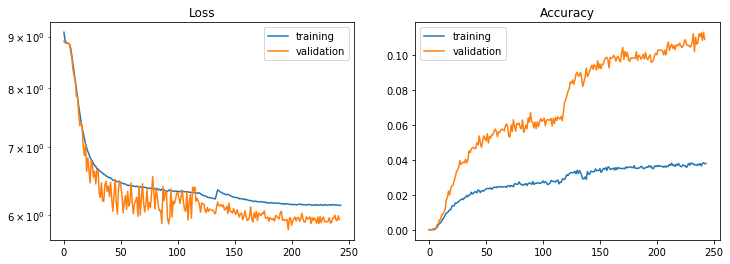

In [10]:
# Plot the training and validation losses.
tloss = np.loadtxt("train.txt")
vloss = np.loadtxt("val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [11]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
softmax = nn.Softmax(dim=1)
model.eval()

Created dataset for events from 0 to 100000


basicCNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=64, out_features=7056, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)

In [78]:
SHIFTED_ERR_RANGE_MIN = tr.PIXEL_ERR_RANGE_MIN - dset.add_shift*tr.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = tr.PIXEL_ERR_RANGE_MAX + dset.add_shift*tr.PIXEL_SIZE
ERR_PIXEL_SIZE = tr.PIXEL_SIZE*(2*dset.add_shift+1)/tr.ERR_SIZE

# Compute sigma_x and sigma_y of the given probability distribution
def compute_sigmas(prob_dist):
    
    sum_x, sum_xsq = 0, 0
    sum_y, sum_ysq = 0, 0
    for i in range(prob_dist.size):
        
        xi = int(i % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
        yi = int(i / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
        
        vi = prob_dist[np.unravel_index(i,prob_dist.shape)]
        sum_x   += xi*vi
        sum_xsq += xi**2*vi
        sum_y   += yi*vi
        sum_ysq += yi**2*vi
    
    # Compute mean and sigma.
    sum_tot = np.sum(prob_dist)
    mean_x = sum_x/sum_tot
    mean_y = sum_y/sum_tot
    sigma_x = (sum_xsq/sum_tot - mean_x**2)**0.5
    sigma_y = (sum_ysq/sum_tot - mean_y**2)**0.5
    
    return sigma_x, sigma_y

In [79]:
evts = np.arange(80000,85000)#100000)

l_evt, l_xtrue, l_ytrue, l_xpred, l_ypred, l_sigmax, l_sigmay = [], [], [], [], [], [], []
for evt in evts:
    
    evt_item = dset[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()
    output_score = model(data)
    
    # Compute the predicted pixel and (x,y) values.
    prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
    ipred = np.argmax(prob)
    xpred = int(ipred % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
    ypred = int(ipred / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
    #print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    # Compute the sigmas of the distribution.
    sigma_x, sigma_y = compute_sigmas(prob)
    
    # Fill the lists.
    l_evt.append(evt)
    l_xtrue.append(evt_lbl[0])
    l_ytrue.append(evt_lbl[1])
    l_xpred.append(xpred)
    l_ypred.append(ypred)
    l_sigmax.append(sigma_x)
    l_sigmay.append(sigma_y)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
        print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))

# Create the dataframe.
evt_dict = {'event': l_evt, 'x_true': l_xtrue, 'y_true': l_ytrue, 'x_pred': l_xpred, 
            'y_pred': l_ypred, 'sigma_x': l_sigmax, 'sigma_y': l_sigmay}
df = pd.DataFrame.from_dict(evt_dict)

# Create derived quantities.
df["sigma_r"] = (df.sigma_x**2 + df.sigma_y**2)**0.5
df["error_x"] = df.x_pred - df.x_true
df["error_y"] = df.y_pred - df.y_true
df["error_r"] = (df.error_x**2 + df.error_y**2)**0.5

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


Text(0, 0.5, 'Counts/bin')

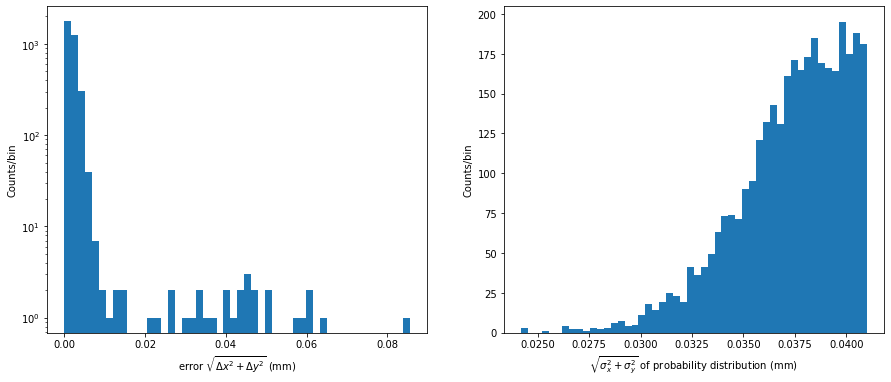

In [103]:
cut_sigma = 0.041

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r < cut_sigma].error_r,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r < cut_sigma].sigma_r,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

[SIGMA = 0.035]: EFF = 0.127, ERR = 0.0017182299924708773
[SIGMA = 0.035500000000000004]: EFF = 0.1548, ERR = 0.0017189331502403126
[SIGMA = 0.036000000000000004]: EFF = 0.1886, ERR = 0.0017376772821851932
[SIGMA = 0.036500000000000005]: EFF = 0.2304, ERR = 0.0017573557145865646
[SIGMA = 0.037000000000000005]: EFF = 0.2698, ERR = 0.0017695688560572683
[SIGMA = 0.037500000000000006]: EFF = 0.321, ERR = 0.001782963509619443
[SIGMA = 0.038000000000000006]: EFF = 0.368, ERR = 0.0018326716724564808
[SIGMA = 0.038500000000000006]: EFF = 0.4232, ERR = 0.001872358718512801
[SIGMA = 0.03900000000000001]: EFF = 0.473, ERR = 0.0019149633620321577
[SIGMA = 0.03950000000000001]: EFF = 0.5216, ERR = 0.0019502996538270773
[SIGMA = 0.04000000000000001]: EFF = 0.5778, ERR = 0.0020721369154320015
[SIGMA = 0.04050000000000001]: EFF = 0.6336, ERR = 0.002100536738745025
[SIGMA = 0.04100000000000001]: EFF = 0.685, ERR = 0.0022720660438158265
[SIGMA = 0.04150000000000001]: EFF = 0.7444, ERR = 0.0025566851329

Text(0, 0.5, 'Efficiency')

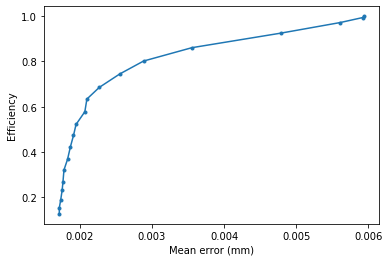

In [102]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.035,0.045,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
softmax = nn.Softmax(dim=1)
model.eval()

Computed index: 2409 for max added shift: 10


Text(0.5, 1.0, 'Incidence point within central pixel')

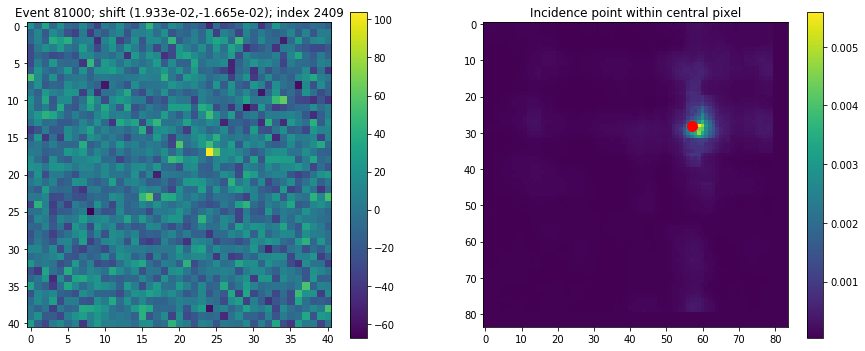

In [80]:
evt_plt = 81000
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = tr.PIXEL_ERR_RANGE_MIN - dset.add_shift*tr.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = tr.PIXEL_ERR_RANGE_MAX + dset.add_shift*tr.PIXEL_SIZE

xbin = int(tr.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,tr.ERR_SIZE-1)

ybin = int(tr.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,tr.ERR_SIZE-1)

print("Computed index:",(ybin*tr.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()

output_score = model(data)
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([tr.ERR_SIZE,tr.ERR_SIZE])

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(122)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within central pixel")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")
